In [1]:
!pip install -q albumentations ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00


In [4]:
import albumentations as A

In [5]:
!git clone https://github.com/Shenggan/BCCD_Dataset

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 13.09 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [6]:
# Import necessary libraries
import os
import yaml
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# Install required packages if not already installed


import albumentations as A

# Setup paths - using your existing BCCD_Dataset
dataset_root = "./BCCD_Dataset"
yolo_dataset = "./BCCD_YOLO"
augmented_dataset = "./BCCD_Augmented"

# Create directories for YOLO format
os.makedirs(f"{yolo_dataset}/images/train", exist_ok=True)
os.makedirs(f"{yolo_dataset}/images/val", exist_ok=True)
os.makedirs(f"{yolo_dataset}/images/test", exist_ok=True)
os.makedirs(f"{yolo_dataset}/labels/train", exist_ok=True)
os.makedirs(f"{yolo_dataset}/labels/val", exist_ok=True)
os.makedirs(f"{yolo_dataset}/labels/test", exist_ok=True)

# Step 3: Convert BCCD dataset to YOLO format
def convert_voc_to_yolo(xml_file, img_width, img_height):
    import xml.etree.ElementTree as ET

    tree = ET.parse(xml_file)
    root = tree.getroot()

    yolo_annotations = []

    for obj in root.findall('object'):
        cls = obj.find('name').text

        # Map class names to indices
        class_mapping = {"RBC": 0, "WBC": 1, "Platelets": 2}
        cls_id = class_mapping.get(cls, -1)

        if cls_id == -1:
            continue

        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # Convert to YOLO format (center_x, center_y, width, height) and normalize
        center_x = ((xmin + xmax) / 2) / img_width
        center_y = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_annotations.append(f"{cls_id} {center_x} {center_y} {width} {height}")

    return yolo_annotations

# Adjust paths for the existing BCCD dataset structure
print("Converting annotations to YOLO format...")

# Identify the locations of annotations and images
annotations_path = os.path.join(dataset_root, "BCCD", "Annotations")
images_path = os.path.join(dataset_root, "BCCD", "JPEGImages")

# Create a data split file
data_split_path = os.path.join(yolo_dataset, "data_split.txt")

# Check if the expected paths exist
if not os.path.exists(annotations_path):
    print(f"Annotations path not found: {annotations_path}")
    # Try to find annotations directory
    for root, dirs, files in os.walk(dataset_root):
        if "Annotations" in dirs:
            annotations_path = os.path.join(root, "Annotations")
            print(f"Found annotations at: {annotations_path}")
            break

if not os.path.exists(images_path):
    print(f"Images path not found: {images_path}")
    # Try to find images directory
    for root, dirs, files in os.walk(dataset_root):
        if "JPEGImages" in dirs:
            images_path = os.path.join(root, "JPEGImages")
            print(f"Found images at: {images_path}")
            break
        # Also check for a different name
        possible_image_dirs = [d for d in dirs if "image" in d.lower() or "jpg" in d.lower()]
        if possible_image_dirs:
            images_path = os.path.join(root, possible_image_dirs[0])
            print(f"Found images at: {images_path}")
            break

# List all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png')) and os.path.exists(os.path.join(annotations_path, f.replace('.jpg', '.xml').replace('.jpeg', '.xml').replace('.png', '.xml')))]

# Create train/val/test split
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

# Save the split information
with open(data_split_path, 'w') as f:
    f.write("train:\n" + "\n".join(train_files) + "\n\n")
    f.write("val:\n" + "\n".join(val_files) + "\n\n")
    f.write("test:\n" + "\n".join(test_files))

# Process each split
for split, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
    for img_file in tqdm(files, desc=f"Processing {split} set"):
        img_path = os.path.join(images_path, img_file)
        xml_file = img_file.replace('.jpg', '.xml').replace('.jpeg', '.xml').replace('.png', '.xml')
        xml_path = os.path.join(annotations_path, xml_file)

        if not os.path.exists(xml_path):
            print(f"Annotation not found: {xml_path}")
            continue

        # Get image dimensions
        with Image.open(img_path) as img:
            img_width, img_height = img.size

        # Convert annotations
        yolo_annotations = convert_voc_to_yolo(xml_path, img_width, img_height)

        # Copy image
        shutil.copy(img_path, f"{yolo_dataset}/images/{split}/{img_file}")

        # Save YOLO annotations
        with open(f"{yolo_dataset}/labels/{split}/{img_file.split('.')[0]}.txt", 'w') as f:
            f.write('\n'.join(yolo_annotations))

# Step 4: Data Augmentation
print("Applying data augmentation...")
os.makedirs(f"{augmented_dataset}/images/train", exist_ok=True)
os.makedirs(f"{augmented_dataset}/labels/train", exist_ok=True)

# Define augmentation pipeline
augmentations = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    A.RandomCrop(height=416, width=416, p=0.3),
    A.Resize(height=640, width=640)
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.4))

# Copy original images and labels
for img_file in os.listdir(f"{yolo_dataset}/images/train"):
    # Copy original image and label
    shutil.copy(
        f"{yolo_dataset}/images/train/{img_file}",
        f"{augmented_dataset}/images/train/{img_file}"
    )

    label_file = f"{img_file.split('.')[0]}.txt"
    label_path = f"{yolo_dataset}/labels/train/{label_file}"

    if os.path.exists(label_path):
        shutil.copy(
            label_path,
            f"{augmented_dataset}/labels/train/{label_file}"
        )

# Apply augmentation to training images
for img_file in tqdm(os.listdir(f"{yolo_dataset}/images/train"), desc="Augmenting images"):
    img_path = f"{yolo_dataset}/images/train/{img_file}"
    label_path = f"{yolo_dataset}/labels/train/{img_file.split('.')[0]}.txt"

    if not os.path.exists(label_path):
        continue

    # Read image and labels
    image = np.array(Image.open(img_path))

    with open(label_path, 'r') as f:
        labels = f.read().strip().split('\n')

    bboxes = []
    class_labels = []

    for label in labels:
        if label:
            parts = label.split()
            cls_id = int(parts[0])
            x, y, w, h = map(float, parts[1:])
            bboxes.append([x, y, w, h])
            class_labels.append(cls_id)

    # Apply augmentation 3 times per image
    for i in range(3):
        try:
            augmented = augmentations(image=image, bboxes=bboxes, class_labels=class_labels)

            aug_image = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_class_labels = augmented['class_labels']

            # Save augmented image
            aug_img_path = f"{augmented_dataset}/images/train/{img_file.split('.')[0]}_aug{i}.jpg"
            Image.fromarray(aug_image).save(aug_img_path)

            # Save augmented labels
            aug_label_path = f"{augmented_dataset}/labels/train/{img_file.split('.')[0]}_aug{i}.txt"
            with open(aug_label_path, 'w') as f:
                for bbox, cls_id in zip(aug_bboxes, aug_class_labels):
                    f.write(f"{cls_id} {' '.join(map(str, bbox))}\n")
        except Exception as e:
            print(f"Error augmenting {img_file}: {str(e)}")

# Copy validation and test sets directly
for split in ["val", "test"]:
    os.makedirs(f"{augmented_dataset}/images/{split}", exist_ok=True)
    os.makedirs(f"{augmented_dataset}/labels/{split}", exist_ok=True)

    for img_file in os.listdir(f"{yolo_dataset}/images/{split}"):
        shutil.copy(
            f"{yolo_dataset}/images/{split}/{img_file}",
            f"{augmented_dataset}/images/{split}/{img_file}"
        )

        label_file = f"{img_file.split('.')[0]}.txt"
        label_path = f"{yolo_dataset}/labels/{split}/{label_file}"

        if os.path.exists(label_path):
            shutil.copy(
                label_path,
                f"{augmented_dataset}/labels/{split}/{label_file}"
            )

# Step 5: Create data.yaml file
data_yaml = {
    'path': os.path.abspath(augmented_dataset),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 3,
    'names': ['RBC', 'WBC', 'Platelets']
}

with open(f"{augmented_dataset}/data.yaml", 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

# Step 6: Train YOLOv8 model
print("Training YOLOv8 model...")
model = YOLO('yolov8n.pt')  # Use 'yolov8s.pt' for slightly better performance

# Train the model
results = model.train(
    data=f"{augmented_dataset}/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    patience=10,
    save=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Step 7: Evaluate the model


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Converting annotations to YOLO format...


Processing test set: 100%|██████████| 73/73 [00:00<00:00, 1781.44it/s]


Applying data augmentation...


Augmenting images:  21%|██        | 49/232 [00:00<00:00, 488.71it/s]

Error augmenting BloodImage_00046.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00046.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00046.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00207.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00207.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00207.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00047.jpg: Please specify 'label_fields' in 'bbox_params' or add l

Augmenting images:  44%|████▍     | 103/232 [00:00<00:00, 517.14it/s]

Error augmenting BloodImage_00340.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00340.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00340.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00091.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00091.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00091.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00223.jpg: Please specify 'label_fields' in 'bbox_params' or add l

Augmenting images:  68%|██████▊   | 157/232 [00:00<00:00, 522.33it/s]

Error augmenting BloodImage_00156.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00156.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00156.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00344.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00344.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00344.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00233.jpg: Please specify 'label_fields' in 'bbox_params' or add l

Augmenting images:  92%|█████████▏| 213/232 [00:00<00:00, 533.54it/s]

Error augmenting BloodImage_00354.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00354.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00354.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00327.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00327.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00327.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00315.jpg: Please specify 'label_fields' in 'bbox_params' or add l

Augmenting images: 100%|██████████| 232/232 [00:00<00:00, 523.44it/s]

Error augmenting BloodImage_00210.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00210.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00210.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00271.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00271.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00271.jpg: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels
Error augmenting BloodImage_00282.jpg: Please specify 'label_fields' in 'bbox_params' or add l


100%|██████████| 6.25M/6.25M [00:00<00:00, 107MB/s]


Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./BCCD_Augmented/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 21.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 125MB/s]


AMP: checks passed ✅


train: Scanning /content/BCCD_Augmented/labels/train... 232 images, 0 backgrounds, 0 corrupt: 100%|██████████| 232/232 [00:00<00:00, 1815.42it/s]

train: New cache created: /content/BCCD_Augmented/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/BCCD_Augmented/labels/val... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 594.25it/s]

val: New cache created: /content/BCCD_Augmented/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       2.4G      1.488      3.195      1.523        141        640: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         59        791     0.0307      0.556       0.14     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.56G        1.3      1.794      1.299        167        640: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         59        791     0.0382      0.634      0.525      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.72G      1.245      1.308      1.285        194        640: 100%|██████████| 15/15 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         59        791      0.653      0.459       0.69      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.74G      1.198      1.183      1.243        247        640: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         59        791      0.824      0.598      0.799      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.76G      1.149      1.115      1.224        220        640: 100%|██████████| 15/15 [00:03<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         59        791      0.869      0.563      0.697      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.78G      1.138      1.049      1.194        194        640: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         59        791      0.863      0.406       0.65      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.79G       1.15      1.053        1.2        205        640: 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         59        791       0.89      0.492      0.705      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.96G      1.126     0.9922       1.18        174        640: 100%|██████████| 15/15 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


                   all         59        791      0.881      0.626      0.809      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.98G      1.121     0.9892      1.165        243        640: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


                   all         59        791      0.838      0.753      0.866      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         3G      1.101     0.9673      1.183        157        640: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         59        791      0.801      0.787      0.883      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.01G      1.084     0.9228      1.152        171        640: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         59        791      0.834      0.805      0.897      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.03G      1.078     0.9234      1.146        252        640: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         59        791        0.8      0.891      0.889      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.05G      1.088     0.9504      1.161        145        640: 100%|██████████| 15/15 [00:03<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         59        791      0.779      0.912      0.886      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.06G      1.069     0.8932      1.145        193        640: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         59        791      0.839      0.887      0.893      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.08G       1.06     0.8789      1.121        178        640: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         59        791      0.819      0.911       0.92      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       3.1G      1.079     0.8927      1.143        234        640: 100%|██████████| 15/15 [00:03<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         59        791      0.824      0.894      0.919      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.12G      1.074     0.8707      1.145        158        640: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         59        791      0.819      0.874      0.914      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.13G      1.078     0.8643      1.138        181        640: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         59        791      0.844      0.904      0.913      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.14G      1.064     0.8437      1.136        205        640: 100%|██████████| 15/15 [00:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         59        791      0.847       0.88      0.899      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.17G       1.04      0.821      1.118        174        640: 100%|██████████| 15/15 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         59        791      0.864      0.895      0.917      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.34G      1.068     0.8153      1.137        225        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         59        791      0.867       0.91      0.933      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.36G      1.019     0.8136      1.109        181        640: 100%|██████████| 15/15 [00:03<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         59        791       0.86      0.875      0.922      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.37G      1.006     0.8236      1.118        123        640: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         59        791      0.835      0.897      0.915      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.39G      1.034     0.7901      1.111        180        640: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         59        791       0.83      0.899      0.898      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.41G      1.043     0.8157      1.133        239        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         59        791      0.845      0.892      0.904      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.42G     0.9981     0.7955      1.107        156        640: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         59        791      0.871      0.869      0.908      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.44G     0.9931     0.7624        1.1        221        640: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         59        791      0.862      0.892      0.897      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.46G       1.01     0.7747      1.109        175        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         59        791      0.849      0.869      0.896      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.47G      1.003     0.7844      1.102        144        640: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


                   all         59        791      0.847      0.882      0.896      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.49G     0.9908     0.7527      1.086        160        640: 100%|██████████| 15/15 [00:03<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         59        791      0.852        0.9      0.913      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       3.5G      1.008     0.7569      1.085        303        640: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         59        791       0.87      0.864      0.919      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.53G     0.9531     0.7269      1.076        170        640: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         59        791      0.862      0.898      0.928      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.54G     0.9725     0.7234      1.085        230        640: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         59        791      0.858       0.91      0.927      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.56G     0.9668     0.7239      1.076        220        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         59        791      0.898      0.875      0.923      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.57G     0.9584     0.7122      1.085        182        640: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         59        791      0.856      0.894      0.919      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.59G     0.9748     0.7309      1.085        253        640: 100%|██████████| 15/15 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         59        791      0.855      0.903       0.92      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.61G     0.9572      0.713      1.075        189        640: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


                   all         59        791      0.855        0.9      0.919      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.63G     0.9496     0.6994      1.076        218        640: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         59        791      0.849      0.902      0.917      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.79G     0.9404     0.6904      1.057        170        640: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         59        791      0.847      0.895      0.918      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.98G     0.9422      0.679      1.065        213        640: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         59        791      0.871      0.903      0.931      0.635


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         4G     0.9635     0.8477      1.081         93        640: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         59        791      0.866      0.885      0.929      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.01G      0.931     0.7249      1.069         96        640: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         59        791      0.811      0.923      0.921      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.02G     0.9228     0.6837      1.068         88        640: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         59        791      0.845      0.873      0.917       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.05G     0.9075     0.6681       1.06        108        640: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         59        791      0.862      0.874      0.923      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.06G     0.9049     0.6512       1.05        103        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         59        791      0.878      0.879      0.924      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.08G     0.8929      0.626      1.052         95        640: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         59        791      0.858      0.893      0.916       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.09G     0.8936     0.6179      1.055        117        640: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         59        791      0.856      0.901      0.915      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.12G      0.885       0.62      1.041        115        640: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         59        791      0.858      0.882      0.914      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.13G      0.879     0.6131      1.038         95        640: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         59        791      0.858      0.883      0.914      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.15G      0.883     0.6099      1.045        132        640: 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         59        791      0.856      0.888      0.915       0.63
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



50 epochs completed in 0.068 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


                   all         59        791       0.87      0.903      0.931      0.636
                   RBC         56        667      0.774      0.835      0.868      0.618
                   WBC         59         60      0.985          1      0.995      0.808
             Platelets         35         64      0.853      0.875      0.931      0.481
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train


In [7]:
print("Evaluating model...")
val_results = model.val()

# Print metrics
print(f"Mean Average Precision (mAP@0.5): {val_results.box.map50:.4f}")
print(f"Mean Average Precision (mAP@0.5:0.95): {val_results.box.map:.4f}")

# Class-specific metrics - using the correct attributes based on the error message
class_names = ['RBC', 'WBC', 'Platelets']

# Initialize total metrics for accuracy calculation
total_correct = 0
total_predictions = 0

for i, class_name in enumerate(class_names):
    try:
        # Get class-specific results using the correct method
        p, r, ap50, ap = val_results.box.class_result(i)

        # Calculate accuracy for this class
        # Accuracy = (True Positives) / (True Positives + False Positives + False Negatives)
        # Here, we are approximating by considering precision as a proxy for accuracy.
        accuracy = p  # You can replace this with actual accuracy calculation if available

        # Add to total metrics for overall accuracy
        total_correct += p  # This can be adjusted if you want to count different metrics for accuracy
        total_predictions += 1

        # Print class-specific metrics
        print(f"{class_name} - Precision: {p:.4f}, Recall: {r:.4f}, AP50: {ap50:.4f}, AP: {ap:.4f}, Accuracy: {accuracy:.4f}")
    except (IndexError, AttributeError) as e:
        print(f"Could not get metrics for {class_name}: {str(e)}")

# Overall accuracy calculation (this is a simplified version)
overall_accuracy = total_correct / total_predictions if total_predictions > 0 else 0
print(f"Overall Accuracy: {overall_accuracy:.4f}")




Evaluating model...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/BCCD_Augmented/labels/val.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


                   all         59        791      0.872      0.903      0.931      0.635
                   RBC         56        667      0.776      0.835      0.868      0.617
                   WBC         59         60      0.985          1      0.995      0.808
             Platelets         35         64      0.854      0.875       0.93      0.481
Speed: 9.4ms preprocess, 16.0ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train2
Mean Average Precision (mAP@0.5): 0.9312
Mean Average Precision (mAP@0.5:0.95): 0.6353
RBC - Precision: 0.7762, Recall: 0.8351, AP50: 0.8680, AP: 0.6165, Accuracy: 0.7762
WBC - Precision: 0.9846, Recall: 1.0000, AP50: 0.9950, AP: 0.8078, Accuracy: 0.9846
Platelets - Precision: 0.8539, Recall: 0.8750, AP50: 0.9305, AP: 0.4814, Accuracy: 0.8539
Overall Accuracy: 0.8715


In [8]:
def visualize_predictions(model, image_paths, class_names, num_samples=5):
    plt.figure(figsize=(15, 15))

    sample_paths = random.sample(image_paths, min(num_samples, len(image_paths)))
    for i, img_path in enumerate(sample_paths):
        results = model.predict(img_path)

        # Get the result image with bounding boxes
        result_img = results[0].plot()
        result_img = np.array(result_img)

        plt.subplot(1, len(sample_paths), i + 1)
        plt.imshow(result_img)
        plt.title(f"Sample {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


image 1/1 /content/BCCD_Augmented/images/test/BloodImage_00362.jpg: 480x640 21 RBCs, 1 WBC, 182.9ms
Speed: 5.7ms preprocess, 182.9ms inference, 15.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/BCCD_Augmented/images/test/BloodImage_00240.jpg: 480x640 20 RBCs, 1 WBC, 1 Platelets, 18.9ms
Speed: 11.6ms preprocess, 18.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/BCCD_Augmented/images/test/BloodImage_00187.jpg: 480x640 22 RBCs, 1 WBC, 2 Plateletss, 10.0ms
Speed: 3.1ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/BCCD_Augmented/images/test/BloodImage_00168.jpg: 480x640 23 RBCs, 1 WBC, 2 Plateletss, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/BCCD_Augmented/images/test/BloodImage_00408.jpg: 480x640 17 RBCs, 1 WBC, 2 Plateletss, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 4.0ms postpr

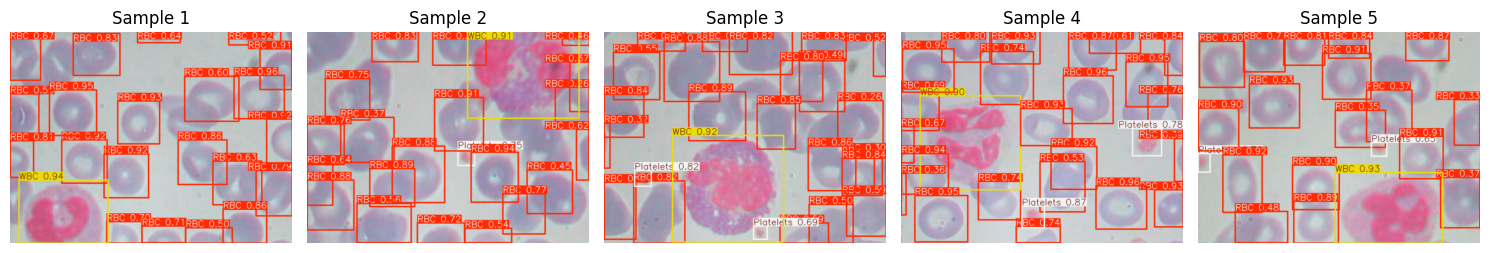

In [9]:
test_image_paths = [os.path.join(augmented_dataset, 'images/test', f) for f in os.listdir(f"{augmented_dataset}/images/test")]
if test_image_paths:
    visualize_predictions(model, test_image_paths, class_names)
else:
    print("No test images available for visualization")

In [10]:
from google.colab import files
files.download('runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>